# Kvantiniai skaičiavimai baigtiniuose kūnuose

In [1]:
import math
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.extensions import Initialize
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.monitor import job_monitor
%matplotlib inline

## Kvantinė Furjė transformacija

In [2]:
def qft(bits=3):
    circuit = QuantumCircuit(
        QuantumRegister(bits, name='x'),
        name=r'QFT')
    for i in range(bits - 1, -1, -1):
        circuit.h(i)
        for j in range(i - 1, -1, -1):
            circuit.cp(pi / (2**(i-j)), j, i)
    return circuit


def iqft(bits=3):
    circuit = QuantumCircuit(
        QuantumRegister(bits, name='x'),
        name=r'IQFT')
    for i in range(bits):
        for j in range(i):
            circuit.cp(-pi / (2**(i-j)), j, i)
        circuit.h(i)
    return circuit

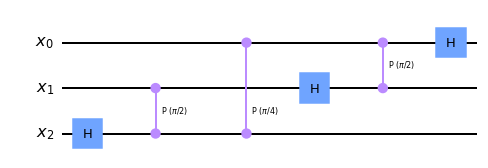

In [3]:
circuit = qft()
circuit.draw(output='mpl')

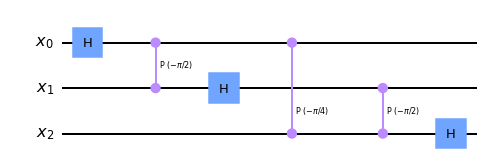

In [4]:
circuit = iqft()
circuit.draw(output='mpl')

## Sudėtis ir atimtis

In [5]:
def add(k=1, bits_s=3, bits_x=3):
    ns = r'ADD' if k == 1 else f'{k} ADD'
    circuit = QuantumCircuit(
        QuantumRegister(bits_s, name='s'),
        QuantumRegister(bits_x, name='x'),
        name=ns)
    for i in range(bits_s, bits_s + bits_x):
        power = 1
        for j in range(i - bits_s, bits_s):
            circuit.cp(k * pi / power, i, j)
            power *= 2
    return circuit


def iadd(k=1, bits_s=3, bits_x=3):
    ns = r'SUB' if k == 1 else f'{k} SUB'
    circuit = QuantumCircuit(
        QuantumRegister(bits_s, name='s'),
        QuantumRegister(bits_x, name='x'),
        name=ns)
    for i in range(bits_s, bits_s + bits_x):
        power = 1
        for j in range(i - bits_s, bits_s):
            circuit.cp(-k * pi / power, i, j)
            power *= 2
    return circuit


def addc(k=1, bits=3):
    ns = f'ADD {k}'
    circuit = QuantumCircuit(
        QuantumRegister(bits, name='s'),
        name=ns)
    power = 1
    for i in range(bits):
        circuit.p(k * pi / power, i)
        power *= 2
    return circuit


def iaddc(k=1, bits=3):
    ns = f'SUB {k}'
    circuit = QuantumCircuit(
        QuantumRegister(bits, name='s'),
        name=ns)
    power = 1
    for i in range(bits):
        circuit.p(-k * pi / power, i)
        power *= 2
    return circuit

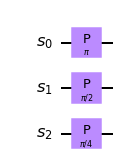

In [6]:
circuit = addc()
circuit.draw(output='mpl')

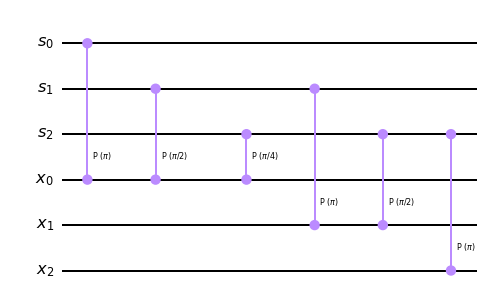

In [7]:
circuit = add()
circuit.draw(output='mpl')

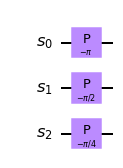

In [8]:
circuit = iaddc()
circuit.draw(output='mpl')

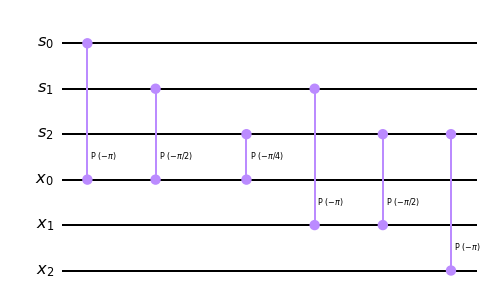

In [9]:
circuit = iadd()
circuit.draw(output='mpl')

## Sudėtis ir atimtis moduliu

In [10]:
def addmod(p, k=1, bits_s=3, bits_x=3):
    ns = f'ADD (mod {p})' if k == 1 else f'{k} ADD (mod {p})'
    circuit = QuantumCircuit(
        QuantumRegister(bits_s, name='s'),
        QuantumRegister(bits_x, name='x'),
        QuantumRegister(1, name='t'),
        name=ns)
    for _ in range(k):
        circuit.compose(add(bits_s=bits_s, bits_x=bits_x).to_gate(),
                        qubits=list(range(0, bits_s + bits_x)), inplace=True)
        circuit.compose(iaddc(p, bits=bits_s).to_gate(),
                        qubits=list(range(0, bits_s)), inplace=True)

        circuit.compose(iqft(bits=bits_s).to_gate(), qubits=list(
            range(0, bits_s)), inplace=True)
        circuit.cx(bits_s - 1, bits_s + bits_x)
        circuit.compose(qft(bits=bits_s).to_gate(), qubits=list(
            range(0, bits_s)), inplace=True)

        circuit.compose(addc(p, bits=bits_s).control(), qubits=[
                        bits_s + bits_x]+list(range(0, bits_s)), inplace=True)
        circuit.compose(iadd(bits_s=bits_s, bits_x=bits_x).to_gate(), qubits=list(
            range(0, bits_s + bits_x)), inplace=True)

        circuit.compose(iqft(bits=bits_s).to_gate(), qubits=list(
            range(0, bits_s)), inplace=True)
        circuit.x(bits_s - 1)
        circuit.cx(bits_s - 1, bits_s + bits_x)
        circuit.x(bits_s - 1)
        circuit.compose(qft(bits=bits_s).to_gate(), qubits=list(
            range(0, bits_s)), inplace=True)

        circuit.compose(add(bits_s=bits_s, bits_x=bits_x).to_gate(), qubits=list(
            range(0, bits_s + bits_x)), inplace=True)

    return circuit


def iaddmod(p, k=1, bits_s=3, bits_x=3):
    ns = f'SUB (mod {p})' if k == 1 else f'{k} SUB (mod {p})'
    circuit = QuantumCircuit(
        QuantumRegister(bits_s, name='s'),
        QuantumRegister(bits_x, name='x'),
        QuantumRegister(1, name='t'),
        name=ns)
    for _ in range(k):
        circuit.compose(iadd(bits_s=bits_s, bits_x=bits_x).to_gate(
        ), qubits=list(range(0, bits_s + bits_x)), inplace=True)
        circuit.compose(iqft(bits=bits_s).to_gate(),
                        qubits=list(range(0, bits_s)), inplace=True)
        circuit.x(bits_s - 1)
        circuit.cx(bits_s - 1, bits_s + bits_x)
        circuit.x(bits_s - 1)
        circuit.compose(qft(bits=bits_s).to_gate(),
                        qubits=list(range(0, bits_s)), inplace=True)
        circuit.compose(add(bits_s=bits_s, bits_x=bits_x).to_gate(
        ), qubits=list(range(0, bits_s + bits_x)), inplace=True)
        circuit.compose(iaddc(p, bits=bits_s).control(), qubits=[
                        bits_s + bits_x]+list(range(0, bits_s)), inplace=True)
        circuit.compose(iqft(bits=bits_s).to_gate(),
                        qubits=list(range(0, bits_s)), inplace=True)
        circuit.cx(bits_s - 1, bits_s + bits_x)
        circuit.compose(qft(bits=bits_s).to_gate(),
                        qubits=list(range(0, bits_s)), inplace=True)
        circuit.compose(addc(p, bits=bits_s).to_gate(),
                        qubits=list(range(0, bits_s)), inplace=True)
        circuit.compose(iadd(bits_s=bits_s, bits_x=bits_x).to_gate(),
                        qubits=list(range(0, bits_s + bits_x)), inplace=True)
    return circuit

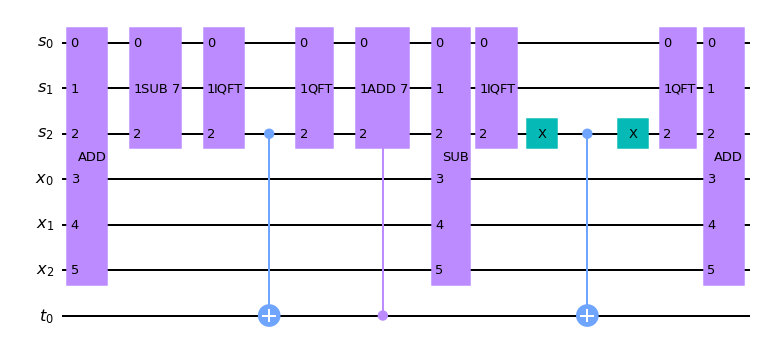

In [11]:
circuit = addmod(7)
circuit.draw(output='mpl')

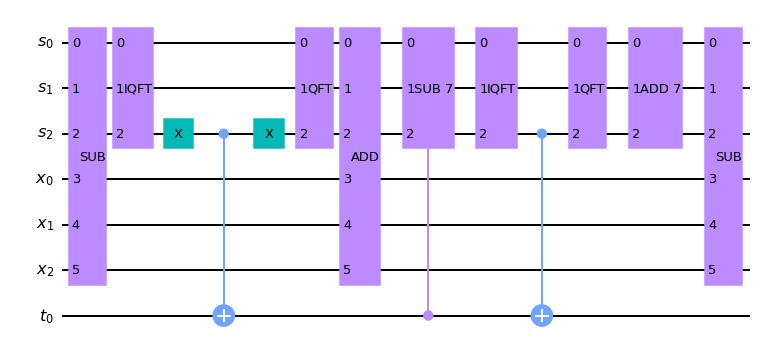

In [12]:
circuit = iaddmod(7)
circuit.draw(output='mpl')

## Daugyba

In [13]:
def mul(bits_s=3, bits_x=3, bits_y=3):
    circuit = QuantumCircuit(
        QuantumRegister(bits_s, name='s'),
        QuantumRegister(bits_x, name='x'),
        QuantumRegister(bits_y, name='y'),
        name=r'MUL')
    power = 1
    for i in range(bits_s + bits_x, bits_s + bits_x + bits_y):
        circuit.compose(add(power, bits_s=bits_s, bits_x=bits_x).control(), qubits=[
                        i]+list(range(0, bits_s + bits_x)), inplace=True)
        power *= 2
    return circuit


def imul(bits_s=3, bits_x=3, bits_y=3):
    circuit = QuantumCircuit(
        QuantumRegister(bits_s, name='s'),
        QuantumRegister(bits_x, name='x'),
        QuantumRegister(bits_y, name='y'),
        name=r'IMUL')
    power = 1
    for i in range(bits_s + bits_x, bits_s + bits_x + bits_y):
        circuit.compose(iadd(power, bits_s=bits_s, bits_x=bits_x).control(), qubits=[
                        i]+list(range(0, bits_s + bits_x)), inplace=True)
        power *= 2
    return circuit
    

def mulmod(p, bits_s=3, bits_x=3, bits_y=3):
    circuit = QuantumCircuit(
        QuantumRegister(bits_s, name='s'),
        QuantumRegister(bits_x, name='x'),
        QuantumRegister(bits_y, name='y'),
        QuantumRegister(1, name='t'),
        name=f'MUL (mod {p})')
    power = 1
    for i in range(bits_s + bits_x, bits_s + bits_x + bits_y):
        circuit.compose(addmod(p, power, bits_s=bits_s, bits_x=bits_x).control(), qubits=[
                        i]+list(range(0, bits_s + bits_x))+[bits_s + bits_x + bits_y], inplace=True)
        power *= 2
    return circuit


def imulmod(p, bits_s=3, bits_x=3, bits_y=3):
    circuit = QuantumCircuit(
        QuantumRegister(bits_s, name='s'),
        QuantumRegister(bits_x, name='x'),
        QuantumRegister(bits_y, name='y'),
        QuantumRegister(1, name='t'),
        name=f'IMUL (mod {p})')
    power = 1
    for i in range(bits_s + bits_x, bits_s + bits_x + bits_y):
        circuit.compose(iaddmod(p, power, bits_s=bits_s, bits_x=bits_x).control(), qubits=[
                        i]+list(range(0, bits_s + bits_x))+[bits_s + bits_x + bits_y], inplace=True)
        power *= 2
    return circuit

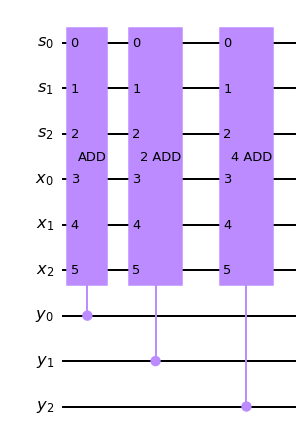

In [14]:
circuit = mul()
circuit.draw(output='mpl')

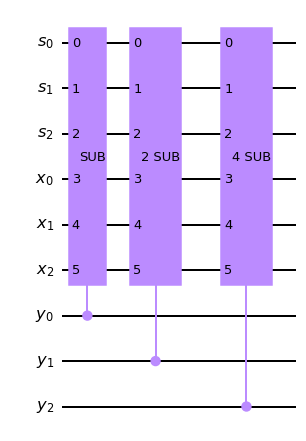

In [15]:
circuit = imul()
circuit.draw(output='mpl')

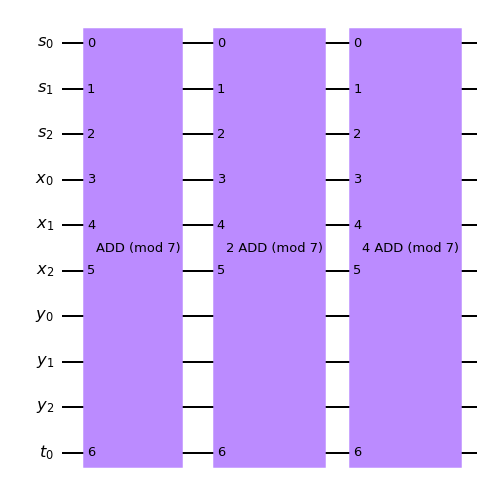

In [16]:
circuit = mulmod(7)
circuit.draw(output='mpl')

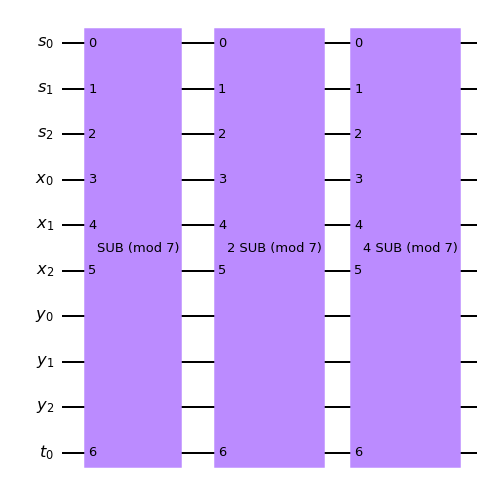

In [17]:
circuit = imulmod(7)
circuit.draw(output='mpl')

## Atvirkštinio skaičiaus radimas Oilerio teorema

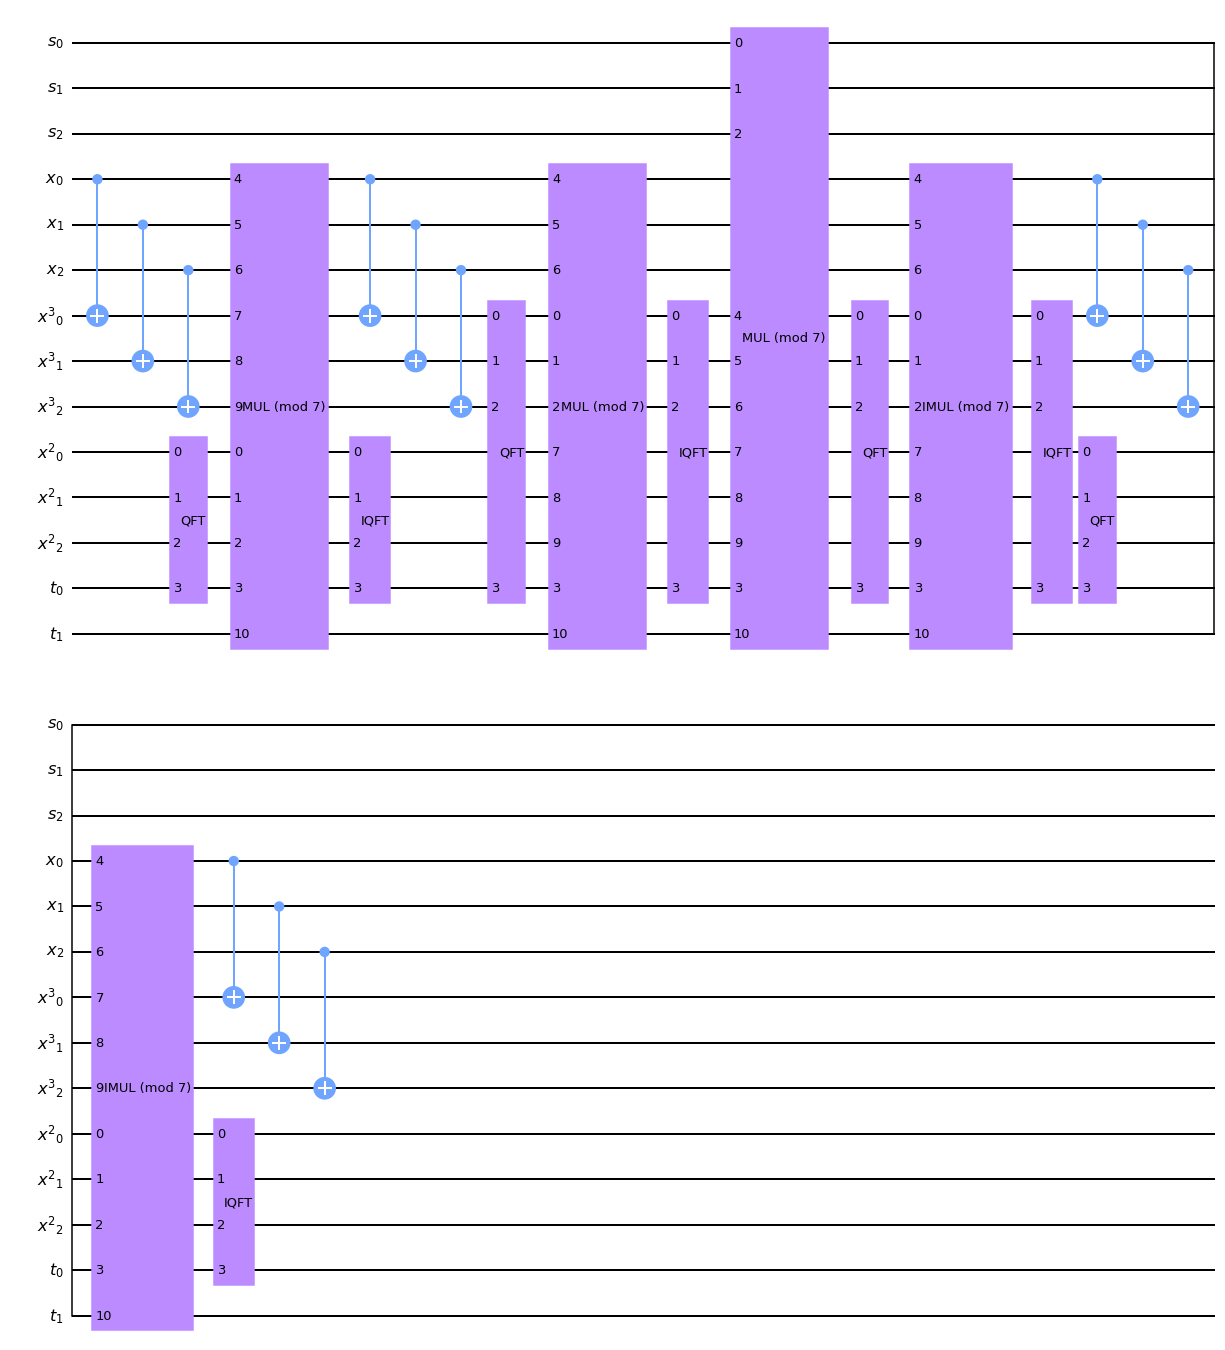

In [18]:
circuit = QuantumCircuit(
    QuantumRegister(3, name='s'),
    QuantumRegister(3, name='x'),
    QuantumRegister(3, name='x^3'),
    QuantumRegister(3, name='x^2'),
    QuantumRegister(2, name='t'))
circuit.cx(3, 6)
circuit.cx(4, 7)
circuit.cx(5, 8)
circuit.compose(qft(bits=4).to_gate(), qubits=list(
    range(9, 12))+[12], inplace=True)
circuit.compose(mulmod(7, bits_s=4, bits_x=3, bits_y=3).to_gate(), qubits=list(
    range(9, 12))+[12]+list(range(3, 6))+list(range(6, 9))+[13], inplace=True)
circuit.compose(iqft(bits=4).to_gate(), qubits=list(
    range(9, 12))+[12], inplace=True)
circuit.cx(3, 6)
circuit.cx(4, 7)
circuit.cx(5, 8)
circuit.compose(qft(bits=4).to_gate(), qubits=list(
    range(6, 9))+[12], inplace=True)
circuit.compose(mulmod(7, bits_s=4, bits_x=3, bits_y=3).to_gate(), qubits=list(
    range(6, 9))+[12]+list(range(3, 6))+list(range(9, 12))+[13], inplace=True)
circuit.compose(iqft(bits=4).to_gate(), qubits=list(
    range(6, 9))+[12], inplace=True)
circuit.compose(mulmod(7, bits_s=4, bits_x=3, bits_y=3).to_gate(), qubits=list(
    range(0, 3))+[12]+list(range(6, 9))+list(range(9, 12))+[13], inplace=True)
# uncomputing
circuit.compose(qft(bits=4).to_gate(), qubits=list(
    range(6, 9))+[12], inplace=True)
circuit.compose(imulmod(7, bits_s=4, bits_x=3, bits_y=3).to_gate(), qubits=list(
    range(6, 9))+[12]+list(range(3, 6))+list(range(9, 12))+[13], inplace=True)
circuit.compose(iqft(bits=4).to_gate(), qubits=list(
    range(6, 9))+[12], inplace=True)
circuit.cx(3, 6)
circuit.cx(4, 7)
circuit.cx(5, 8)
circuit.compose(qft(bits=4).to_gate(), qubits=list(
    range(9, 12))+[12], inplace=True)
circuit.compose(imulmod(7, bits_s=4, bits_x=3, bits_y=3).to_gate(), qubits=list(
    range(9, 12))+[12]+list(range(3, 6))+list(range(6, 9))+[13], inplace=True)
circuit.compose(iqft(bits=4).to_gate(), qubits=list(
    range(9, 12))+[12], inplace=True)
circuit.cx(3, 6)
circuit.cx(4, 7)
circuit.cx(5, 8)
circuit.draw(output='mpl')

## Groverio paieška

In [19]:
def diffuser(bits=3):
    circuit = QuantumCircuit(
        QuantumRegister(bits, name='x'),
        name=f'D')
    for i in range(bits):
        circuit.h(i)
    for i in range(bits):
        circuit.x(i)
    circuit.h(bits-1)
    circuit.mcx(list(range(bits-1)), bits-1)
    circuit.h(bits-1)
    for i in range(bits):
        circuit.x(i)
    for i in range(bits):
        circuit.h(i)
    return circuit

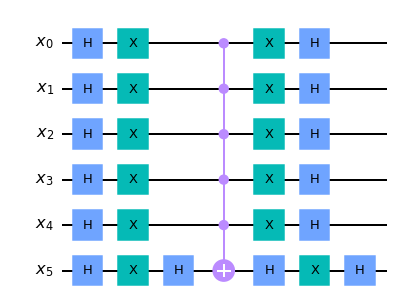

In [20]:
circuit = diffuser(bits=6)
circuit.draw(output='mpl')

## Tiesinės lygčių sistemos sprendimas

In [21]:
def plot_solution(counts, solution=None):
    best_state = None
    best_count = -1
    if solution is None:
        for state, count in counts.items():
            if count > best_count:
                best_state = state
                best_count = count
    else:
        best_state = solution
        best_count = counts[best_state]
    best_x = int(best_state[:3], base=2)
    best_y = int(best_state[3:], base=2)
    plt.bar([0, 1], [best_count / 1024, (1024 - best_count) / 1024])
    plt.xticks([0, 1], [f'x = {best_x}, y = {best_y}', 'kiti'])
    for i, v in enumerate([best_count / 1024, (1024 - best_count) / 1024]):
        plt.text(i - 0.075, v + 0.05, f'{v:.3f}')
    plt.ylim([0, 1.2])
    plt.xlabel('Sprendiniai')
    plt.ylabel('Tikimybė')
    plt.title('Lygčių sistemos sprendiniai')
    plt.show()

In [22]:
circuit = QuantumCircuit(
    QuantumRegister(3, name='x'),
    QuantumRegister(3, name='y'),
    QuantumRegister(3, name='a'),
    QuantumRegister(3, name='b'),
    QuantumRegister(2, name='t'),
    ClassicalRegister(6))
for i in range(6):
    circuit.h(i)
for _ in range(6):
    circuit.compose(qft(bits=4).to_gate(), qubits=list(
        range(6, 9))+[12], inplace=True)
    circuit.compose(addmod(7, 2, bits_s=4).to_gate(),
                    qubits=list(range(6, 9))+[12]+list(range(0, 3))+[13], inplace=True)
    circuit.compose(addmod(7, 3, bits_s=4).to_gate(),
                    qubits=list(range(6, 9))+[12]+list(range(3, 6))+[13], inplace=True)
    circuit.compose(iqft(bits=4).to_gate(), qubits=list(
        range(6, 9))+[12], inplace=True)
    circuit.compose(qft(bits=3).to_gate(), qubits=list(
        range(6, 9)), inplace=True)
    circuit.compose(iaddc(5, bits=3).to_gate(),
                    qubits=list(range(6, 9)), inplace=True)
    circuit.barrier()
    circuit.compose(qft(bits=4).to_gate(), qubits=list(
        range(9, 12))+[12], inplace=True)
    circuit.compose(addmod(7, 1, bits_s=4).to_gate(),
                    qubits=list(range(9, 12))+[12]+list(range(0, 3))+[13], inplace=True)
    circuit.compose(addmod(7, 2, bits_s=4).to_gate(),
                    qubits=list(range(9, 12))+[12]+list(range(3, 6))+[13], inplace=True)
    circuit.compose(iqft(bits=4).to_gate(), qubits=list(
        range(9, 12))+[12], inplace=True)
    circuit.compose(qft(bits=3).to_gate(), qubits=list(
        range(9, 12)), inplace=True)
    circuit.compose(iaddc(3, bits=3).to_gate(),
                    qubits=list(range(9, 12)), inplace=True)
    circuit.barrier()
    circuit.compose(iqft(bits=3).to_gate(),
                    qubits=list(range(6, 9)), inplace=True)
    circuit.compose(iqft(bits=3).to_gate(), qubits=list(
        range(9, 12)), inplace=True)
    for i in range(6, 12):
        circuit.x(i)
    circuit.x(13)
    circuit.h(13)
    circuit.mcx(list(range(6, 12)), 13)
    circuit.h(13)
    circuit.x(13)
    for i in range(6, 12):
        circuit.x(i)
    circuit.compose(qft(bits=3).to_gate(),
                    qubits=list(range(9, 12)), inplace=True)
    circuit.compose(qft(bits=3).to_gate(),
                    qubits=list(range(6, 9)), inplace=True)
    circuit.barrier()
    circuit.compose(addc(3, bits=3).to_gate(),
                    qubits=list(range(9, 12)), inplace=True)
    circuit.compose(iqft(bits=3).to_gate(),
                    qubits=list(range(9, 12)), inplace=True)
    circuit.compose(qft(bits=4).to_gate(), qubits=list(
        range(9, 12))+[12], inplace=True)
    circuit.compose(iaddmod(7, 2, bits_s=4).to_gate(),                    qubits=list(
        range(9, 12))+[12]+list(range(3, 6))+[13], inplace=True)
    circuit.compose(iaddmod(7, 1, bits_s=4).to_gate(),                    qubits=list(
        range(9, 12))+[12]+list(range(0, 3))+[13], inplace=True)
    circuit.compose(iqft(bits=4).to_gate(), qubits=list(
        range(9, 12))+[12], inplace=True)
    circuit.barrier()
    circuit.compose(addc(5, bits=3).to_gate(),
                    qubits=list(range(6, 9)), inplace=True)
    circuit.compose(iqft(bits=3).to_gate(),
                    qubits=list(range(6, 9)), inplace=True)
    circuit.compose(qft(bits=4).to_gate(), qubits=list(
        range(6, 9))+[12], inplace=True)
    circuit.compose(iaddmod(7, 3, bits_s=4).to_gate(),                    qubits=list(
        range(6, 9))+[12]+list(range(3, 6))+[13], inplace=True)
    circuit.compose(iaddmod(7, 2, bits_s=4).to_gate(),                    qubits=list(
        range(6, 9))+[12]+list(range(0, 3))+[13], inplace=True)
    circuit.compose(iqft(bits=4).to_gate(), qubits=list(
        range(6, 9))+[12], inplace=True)

    circuit.compose(diffuser(bits=6).to_gate(),
                    qubits=list(range(0, 6)), inplace=True)
circuit.measure(list(range(0, 6)), list(range(0, 6)))

### Vykdymas kvantiniu simuliatoriumi

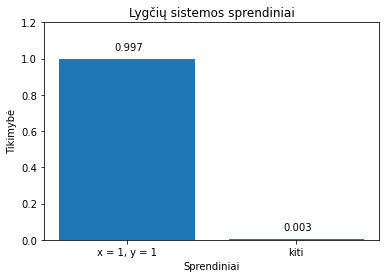

In [23]:
qasm_backend = Aer.get_backend('qasm_simulator')
results = execute(circuit, backend=qasm_backend,
                  shots=1024).result()
counts = results.get_counts()
plot_solution(counts)

### Bandymas vykdyti „IBM“ „ibmq_16_melbourne“ kvantiniu kompiuteriu

In [24]:
def run_on_real_device():
    provider = IBMQ.load_account()
    device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 14 and
                                        not x.configuration().simulator and x.status().operational == True))
    print('Running on current least busy device', device)
    transpiled_circuit = transpile(
        circuit, device, optimization_level=3)
    print('Circuit transpiled')
    qobj = assemble(transpiled_circuit)
    print('Circuit assembled')
    job = device.run(qobj)
    job_monitor(job, interval=2)
    results = job.result()
    counts = results.get_counts(circuit)

# IBMQJobFailureError: Circuit runtime is greater than the device repetition rate

### Vykdymas paklaidas modeliuojančiu simuliatoriumi

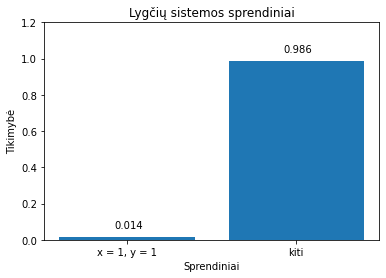

In [25]:
def run_on_noisy_simulator():
    provider = IBMQ.load_account()
    backend = provider.get_backend('ibmq_16_melbourne')
    noise_model = NoiseModel.from_backend(backend)
    coupling_map = backend.configuration().coupling_map
    basis_gates = noise_model.basis_gates
    device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 14 and
                                          x.configuration().simulator and x.status().operational == True))
    print('Running on current least busy device', device)
    transpiled_circuit = transpile(
        circuit, device, optimization_level=3)
    print('Circuit transpiled')
    job = execute(transpiled_circuit, backend=device,
                  coupling_map=coupling_map,
                  basis_gates=basis_gates,
                  noise_model=noise_model, shots=1024)
    job_monitor(job, interval=2)
    result = job.result()
    counts = result.get_counts(0)
    print(counts)

counts = {'000000': 26, '000001': 16, '010000': 19, '010001': 22, '010010': 22, '010011': 15, '010100': 14, '010101': 13, '010110': 11, '010111': 10, '011000': 15, '011001': 9, '011010': 14, '011011': 18, '011100': 11, '011101': 16, '011110': 16, '011111': 16, '000010': 16, '100000': 27, '100001': 23, '100010': 21, '100011': 23, '100100': 15, '100101': 18, '100110': 19, '100111': 17, '101000': 22, '101001': 13, '101010': 17, '101011': 11, '101100': 16,
          '101101': 13, '101110': 12, '101111': 17, '000011': 14, '110000': 25, '110001': 23, '110010': 13, '110011': 16, '110100': 12, '110101': 10, '110110': 11, '110111': 10, '111000': 17, '111001': 13, '111010': 11, '111011': 12, '111100': 20, '111101': 15, '111110': 16, '111111': 8, '000100': 23, '000101': 17, '000110': 18, '000111': 12, '001000': 23, '001001': 14, '001010': 19, '001011': 12, '001100': 15, '001101': 14, '001110': 19, '001111': 9}

plot_solution(counts, '001001')